### 绘制切线

In [3]:
%matplotlib inline
import numpy as np
from matplotlib_inline import backend_inline
from d2l import torch as d2l


def f(x):
    return 3 * x ** 2 - 4 * x

In [4]:
def use_svg_display():  #@save
    """使用svg格式在Jupyter中显示绘图"""
    backend_inline.set_matplotlib_formats('svg')

In [5]:
def set_figsize(figsize=(3.5, 2.5)):  #@save
    """设置matplotlib的图表大小"""
    use_svg_display()
    d2l.plt.rcParams['figure.figsize'] = figsize

In [6]:
#@save
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [7]:
#@save
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点"""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else d2l.plt.gca()

    # 如果X有一个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

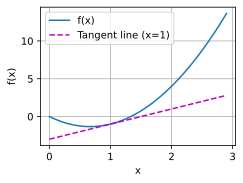

In [8]:
x = np.arange(0, 3, 0.1)
plot(x, [f(x), 2 * x - 3], 'x', 'f(x)', legend=['f(x)', 'Tangent line (x=1)'])

## 自动微分

实际中，根据设计好的模型，系统会构建一个**计算图**（computational graph）， 来跟踪计算是哪些数据通过哪些操作组合起来产生输出。 自动微分使系统能够随后反向传播梯度。 这里，**反向传播**（backpropagate）意味着跟踪整个计算图，填充关于每个参数的偏导数。

对$u = 2 \mathbf{x}^\top \mathbf{x}$关于列向量$\mathbf{x}$求导

[**在我们计算$y$关于$\mathbf{x}$的梯度之前，需要一个地方来存储梯度。**]
重要的是，我们不会在每次对一个参数求导时都分配新的内存。
因为我们经常会成千上万次地更新相同的参数，每次都分配新的内存可能很快就会将内存耗尽。
注意，一个标量函数关于向量$\mathbf{x}$的梯度是向量，并且与$\mathbf{x}$具有相同的形状。


In [21]:
import torch

x = torch.arange(4., requires_grad=True)
# x.requires_grad_(True)

x

tensor([0., 1., 2., 3.], requires_grad=True)

In [22]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

#### [**通过调用反向传播函数来自动计算`y`关于`x`每个分量的梯度**]

In [23]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [24]:
x.grad == 4 * x

tensor([True, True, True, True])

计算`x`的另一个函数
- 默认情况下，PyTorch会**累积**梯度，需要清除之前的值
- **x.grad.zero_()**

In [25]:
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([ 1.,  5.,  9., 13.])

### 非标量变量的反向传播
### 向量和矩阵相互之间的求导在深度学习中**很少**

当`y`不是标量时，向量`y`关于向量`x`的导数的最自然解释是一个矩阵。
对于高阶和高维的`y`和`x`，求导的结果可以是一个高阶张量。

然而，虽然这些更奇特的对象确实出现在高级机器学习中（包括[**深度学习中**]），
但当调用向量的反向计算时，我们通常会试图计算一批训练样本中每个组成部分的损失函数的导数。
这里(**，我们的目的不是计算微分矩阵，而是单独计算批量中每个样本的偏导数之和。**)

In [27]:
# 对非标量调用backward需要传入一个gradient参数，该参数指定微分函数关于self的梯度。
# 本例只想求偏导数的和，所以传递一个1的梯度是合适的
x.grad.zero_()
y = x * x
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

### **分离计算**

- 有时，我们希望[**将某些计算移动到记录的计算图之外**]
- 如：假设`y`是作为`x`的函数计算的，而`z`则是作为`y`和`x`的函数计算的。
想象一下，我们想计算`z`关于`x`的梯度
- 下面的反向传播函数计算`z=u*x`关于`x`的偏导数，同时将`u`作为常数处理，
而不是`z=x*x*x`关于`x`的偏导数

In [32]:
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

In [33]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

### Python控制流的梯度计算

- 使用自动微分的一个好处：**即使构建函数的计算图需要通过Python控制流（如条件、循环或任意函数调用），仍然可以计算得到的变量的梯度**
- `while`循环的迭代次数和`if`语句的结果都取决于输入`a`的值

In [3]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

a = torch.randn(size=(), requires_grad=True)  # a是标量张量，会对a记录计算图且计算梯度
d = f(a)  # f(a)是一个线性分段函数，f(a)=k·a
d.backward()
a.grad == d / a

tensor(True)

## 小结

* 深度学习框架可以自动计算导数：我们首先将梯度附加到想要对其计算偏导数的变量上，然后记录目标值的计算，执行它的反向传播函数，并访问得到的梯度。

## 练习

1. 为什么计算二阶导数比一阶导数的开销要更大？
1. 在运行反向传播函数之后，立即再次运行它，看看会发生什么。
1. 在控制流的例子中，我们计算`d`关于`a`的导数，如果将变量`a`更改为随机向量或矩阵，会发生什么？
1. 重新设计一个求控制流梯度的例子，运行并分析结果。
1. 使$f(x)=\sin(x)$，绘制$f(x)$和$\frac{df(x)}{dx}$的图像，其中后者不使用$f'(x)=\cos(x)$


1. 额外的计算复杂度，存储需求增加，反向传播的链式法则（链式法则的每一层都需要额外的反向传播，这进一步增加了复杂度）
2. 在执行一次 backward() 后，如果没有重新进行前向传播，第二次运行 backward() 会引发错误——PyTorch的计算图默认在反向传播完成后会被**释放**
- 要想保留，可以`y.backward(retain_graph=True)`
3. 如果将 a 改为随机向量或矩阵，反向传播仍然会正常工作，PyTorch 会计算每个元素的梯度，并将结果存储在 a.grad 中；对于标量，梯度是单一值；对于向量或矩阵，梯度是对应形状的张量

3. 举一个例子（仍是使用函数`f(x)`）

In [8]:
a = torch.rand((3, 3), requires_grad=True)
d = f(a) # d是一个非标量张量
d.backward(torch.ones_like(a)) # torch.ones_like(a)是backward()函数的gradient参数
a.grad

tensor([[1024., 1024., 1024.],
        [1024., 1024., 1024.],
        [1024., 1024., 1024.]])

4. 举一个例子

In [9]:
import torch

def f_control(a):
    if a.sum() > 0:
        return a ** 2
    else:
        return a ** 3

a = torch.randn((2, 2), requires_grad=True)
b = f_control(a)
print(b.shape)
b.sum().backward()
a.grad

torch.Size([2, 2])


tensor([[1.6255, 0.3156],
        [0.5801, 0.2490]])

5. 通过自动求导计算$f(x)=\sin(x)$的导数，并绘制图像
- 当尝试讲一个带有**梯度跟踪**（`requries_grad=True`）的张量转换为NumPy数组时，PyTorch会禁止直接进行这种操作，因为NumPy*不支持自动求导*
- `detach()`可以用来切断张量和计算图的联系，得到一个不再跟踪梯度的张量，随后可以将这个张量转换为NumPy数组
- `detach()`用于从当前计算图中分离张量，生成一个新的张量，该张量不再与计算图相关联，也不再跟踪梯度信息

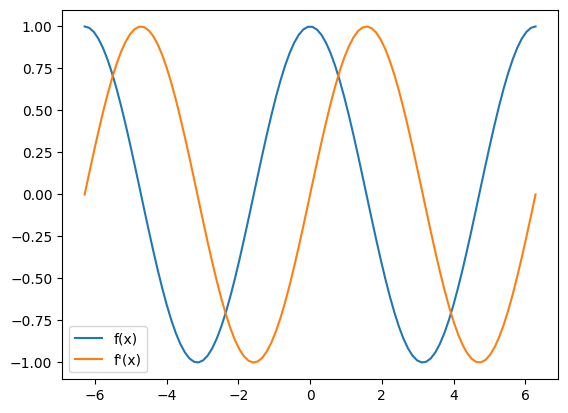

In [20]:
import matplotlib.pyplot as plt
import numpy as np

x = torch.linspace(-2 * np.pi, 2 * np.pi, 100, requires_grad=True)
f_x = torch.sin(x)

f_x.sum().backward()
grad = x.grad

# 这个部分！！
x_np = x.detach().numpy()
f_x_np = f_x.detach().numpy()
grad_np = grad.numpy()

plt.plot(x_np, grad_np, label='f(x)')
plt.plot(x_np, f_x_np, label="f'(x)")
plt.legend()
plt.show()

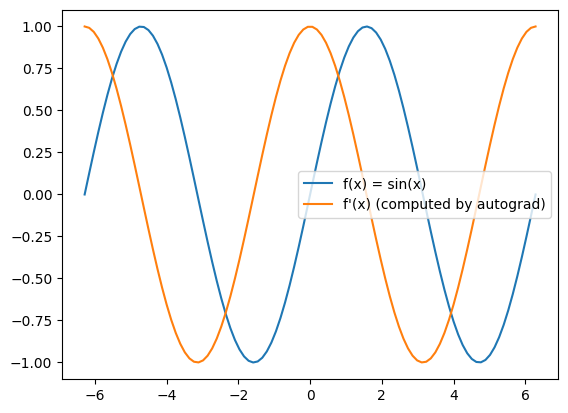

In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# 定义 f(x) = sin(x)
x = torch.linspace(-2 * np.pi, 2 * np.pi, 100, requires_grad=True)
f_x = torch.sin(x)

# 计算 f'(x) 的梯度
f_x.sum().backward()

# 转换为 NumPy 格式用于绘图
x_np = x.detach().numpy()
f_x_np = f_x.detach().numpy()
grad_np = x.grad.numpy()

# 绘制 f(x) 和 df(x)/dx 的图像
plt.plot(x_np, f_x_np, label='f(x) = sin(x)')
plt.plot(x_np, grad_np, label="f'(x) (computed by autograd)")
plt.legend()
plt.show()


## 概率论

- PyTorch 提供了 概率分布模块，torch.distributions 包含了许多常见的概率分布
- `.sample`采样

In [22]:
import torch

from torch.distributions import multinomial
from d2l import torch as d2l

- 在估计一个骰子的公平性时，我们希望从同一分布中生成多个样本。 如果用Python的for循环来完成这个任务，速度会**慢**得惊人  
- 因此我们使用深度学习框架的函数同时抽取多个样本，得到我们想要的任意形状的独立样本数组

In [23]:
fair_probs = torch.ones([6]) / 6
multinomial.Multinomial(1, fair_probs).sample()

tensor([0., 0., 0., 1., 0., 0.])

In [24]:
multinomial.Multinomial(10, fair_probs).sample()

tensor([0., 2., 3., 2., 0., 3.])

In [26]:
multinomial.Multinomial(1000, fair_probs).sample() / 10000

tensor([0.0149, 0.0157, 0.0150, 0.0187, 0.0179, 0.0178])

概率如何随着时间的推移收敛到真实概率
- `.sample(500)`：500解释为**采样的批次数量**
- `.sample((500, ))`：**进行500次实验**，在此生成的是一个形状为`(500, 6) 的张量

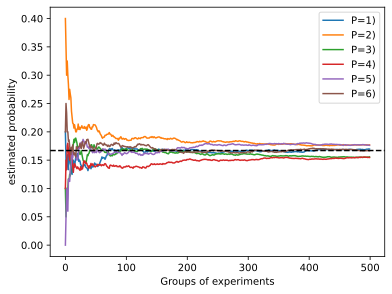

In [30]:
counts = multinomial.Multinomial(10, fair_probs).sample((500,)) # 得到一个(500,6)的张量
cum_counts = counts.cumsum(dim=0)
estimates = cum_counts / cum_counts.sum(dim=1, keepdims=True)

d2l.set_figsize((6, 4.5))
for i in range(6):
    d2l.plt.plot(estimates[:, i].numpy(), label='P=' + str(i + 1) + ')')
d2l.plt.axhline(y=0.167, color='black', linestyle='dashed')
plt.xlabel('Groups of experiments') 
d2l.plt.gca().set_ylabel('estimated probability')
plt.legend()

### 练习

1. 进行$m=500$组实验，每组抽取$n=10$个样本。改变$m$和$n$，观察和分析实验结果。
2. 给定两个概率为$P(\mathcal{A})$和$P(\mathcal{B})$的事件，计算$P(\mathcal{A} \cup \mathcal{B})$和$P(\mathcal{A} \cap \mathcal{B})$的上限和下限。（提示：使用[友元图](https://en.wikipedia.org/wiki/Venn_diagram)来展示这些情况。)
3. 假设我们有一系列随机变量，例如$A$、$B$和$C$，其中$B$只依赖于$A$，而$C$只依赖于$B$，能简化联合概率$P(A, B, C)$吗？（提示：这是一个[马尔可夫链](https://en.wikipedia.org/wiki/Markov_chain)。)
4. 在 :numref:`subsec_probability_hiv_app`中，第一个测试更准确。为什么不运行第一个测试两次，而是同时运行第一个和第二个测试?

1. 练习1

In [33]:
import torch

from torch.distributions import multinomial

def test(n, m):
    probs = torch.tensor([0.1, 0.15, 0.3, 0.2, 0.15, 0.1])
    dist = multinomial.Multinomial(n, probs)
    
    samples = dist.sample((m,))
    
    counts = samples.sum(axis=0)
    estimates = counts / counts.sum()

    return estimates

test(10, 1000)

tensor([0.0955, 0.1563, 0.3006, 0.1968, 0.1511, 0.0997])

4. 练习4
- 两个不同的测试，尽管第二个测试的准确率较低，但因为它提供了独立的证据，结合**贝叶斯定理**，可以更大幅度地提升预测的可信度
- 而重复同一个测试，带来的只是同样的错误来源，信息增量不足，无法显著提高结果的准确性
- **独立性带来更多的信息**

## 查阅文档

### 查找模块中的所有函数和类
为了知道模块中可以调用那些函数和类，可以使用`dir`函数

In [34]:
import torch

dir((torch.distributions))[:5]

['AbsTransform', 'AffineTransform', 'Bernoulli', 'Beta', 'Binomial']

### 查找特定函数和类的用法
调用`help`函数

In [35]:
help(torch.ones)

Help on built-in function ones in module torch:

ones(...)
    ones(*size, *, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) -> Tensor
    
    Returns a tensor filled with the scalar value `1`, with the shape defined
    by the variable argument :attr:`size`.
    
    Args:
        size (int...): a sequence of integers defining the shape of the output tensor.
            Can be a variable number of arguments or a collection like a list or tuple.
    
    Keyword arguments:
        out (Tensor, optional): the output tensor.
        dtype (:class:`torch.dtype`, optional): the desired data type of returned tensor.
            Default: if ``None``, uses a global default (see :func:`torch.set_default_dtype`).
        layout (:class:`torch.layout`, optional): the desired layout of returned Tensor.
            Default: ``torch.strided``.
        device (:class:`torch.device`, optional): the desired device of returned tensor.
            Default: if ``None``, us

再jupyter记事本中，可以使用`?`指令显示文档，使用`??`显示该函数的Python代码

In [36]:
torch.ones?

Docstring:
ones(*size, *, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) -> Tensor

Returns a tensor filled with the scalar value `1`, with the shape defined
by the variable argument :attr:`size`.

Args:
    size (int...): a sequence of integers defining the shape of the output tensor.
        Can be a variable number of arguments or a collection like a list or tuple.

Keyword arguments:
    out (Tensor, optional): the output tensor.
    dtype (:class:`torch.dtype`, optional): the desired data type of returned tensor.
        Default: if ``None``, uses a global default (see :func:`torch.set_default_dtype`).
    layout (:class:`torch.layout`, optional): the desired layout of returned Tensor.
        Default: ``torch.strided``.
    device (:class:`torch.device`, optional): the desired device of returned tensor.
        Default: if ``None``, uses the current device for the default tensor type
        (see :func:`torch.set_default_device`). :attr:`device` wil